In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

#import pmdarima as pm


Wczytanie i podział danych

In [51]:
data = pd.read_csv(r"C:\Users\rafal\OneDrive\Dokumente\GitHub\Komputerowa-analiza-szeregow-czasowych\GlobalTemperatures2.csv")
data['dt'] = pd.to_datetime(data['dt']).dt.to_period('M').astype(str)
month = data['dt']
time = np.arange(0,len(month),1)
temperature = data['LandAverageTemperature'] 

Wizualizacja

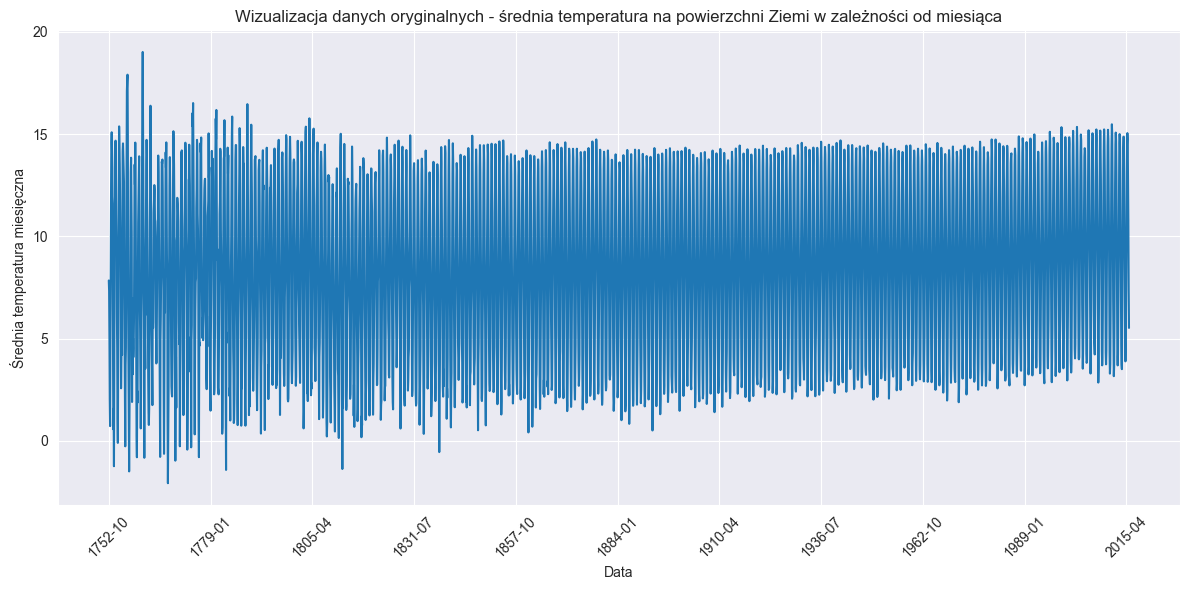

In [52]:
num_labels = 10  # Liczba etykiet, które mają być widoczne
indices = list(range(0, len(month), len(month) // num_labels))  # Indeksy równomiernie rozmieszczonych dat
selected_months = [month[i] for i in indices]  # Wybrane daty

plt.figure(figsize=(12, 6))
plt.plot(month, temperature)
plt.xticks(ticks=indices, labels=selected_months, rotation=45)  # Ustawienie etykiet osi X
plt.xlabel('Data')
plt.ylabel('Średnia temperatura miesięczna')
plt.title('Wizualizacja danych oryginalnych - średnia temperatura na powierzchni Ziemi w zależności od miesiąca')
plt.tight_layout()  # Zapewnienie lepszej estetyki wykresu
plt.show()


Sprawdzenie, czy są puste rekordy

In [53]:
data_info = data.info()
data_head = data.head()
data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159 entries, 0 to 3158
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3159 non-null   object 
 1   LandAverageTemperature                     3159 non-null   float64
 2   LandAverageTemperatureUncertainty          3159 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 222.2+ KB


(None,
         dt  LandAverageTemperature  LandAverageTemperatureUncertainty  \
 0  1752-10                   7.839                              2.754   
 1  1752-11                   7.335                              2.747   
 2  1752-12                   5.086                              2.982   
 3  1753-01                   2.039                              3.478   
 4  1753-02                   0.715                              6.341   
 
    LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
 0                 NaN                            NaN                 NaN   
 1                 NaN                            NaN                 NaN   
 2                 NaN                            NaN                 NaN   
 3                 NaN                            NaN                 NaN   
 4                 NaN                            NaN                 NaN   
 
    LandMinTemperatureUncertainty  LandAndOceanAverageTemperature  \
 0            

Obserwacje odstające, statystyki opisowe dla zmiennej rainfalls

In [54]:
temperature_stats = data['LandAverageTemperature'].describe()

Q1 = data['LandAverageTemperature'].quantile(0.25)
Q3 = data['LandAverageTemperature'].quantile(0.75)
IQR = Q3 - Q1
outlier_thresholds = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
outliers = data[(data['LandAverageTemperature'] < outlier_thresholds[0]) | 
                (data['LandAverageTemperature'] > outlier_thresholds[1])]

temperature_stats, outliers

(count    3159.000000
 mean        8.377803
 std         4.378687
 min        -2.080000
 25%         4.318500
 50%         8.618000
 75%        12.548500
 max        19.021000
 Name: LandAverageTemperature, dtype: float64,
 Empty DataFrame
 Columns: [dt, LandAverageTemperature, LandAverageTemperatureUncertainty, LandMaxTemperature, LandMaxTemperatureUncertainty, LandMinTemperature, LandMinTemperatureUncertainty, LandAndOceanAverageTemperature, LandAndOceanAverageTemperatureUncertainty]
 Index: [])

Sprawdzenie ciągłości miesięcy 

In [55]:
for i in range(1, len(month)):
    m_present = int(month[i][-2:])
    y_present = int(month[i][:4])
    m_previous = int(month[i-1][-2:])
    y_previous = int(month[i-1][:4])
    if m_present != m_previous + 1:
        if m_present == m_previous - 11:
            if y_present != y_previous + 1:
                print(f"Występuje brak ciągłości miesięcy między: {month[i-1]} a {month[i]}")
                break
        else:
            print(f"Występuje brak ciągłości miesięcy między: {month[i-1]} a {month[i]}")
            break
    if i == len(month)-1:
        print("W miesiącach nie brakuje danych, ciąłość jest zachowana")


W miesiącach nie brakuje danych, ciąłość jest zachowana


Przygotowanie zbioru testowego i treningowego

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

ACF i PACF

In [58]:
h_max = 40

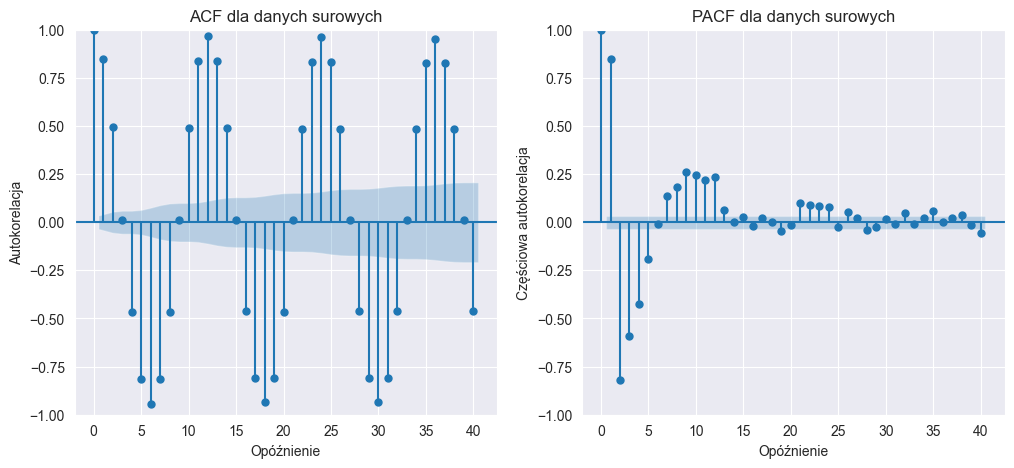

In [59]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_acf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')

plt.subplot(122)
plot_pacf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych surowych')

plt.show()

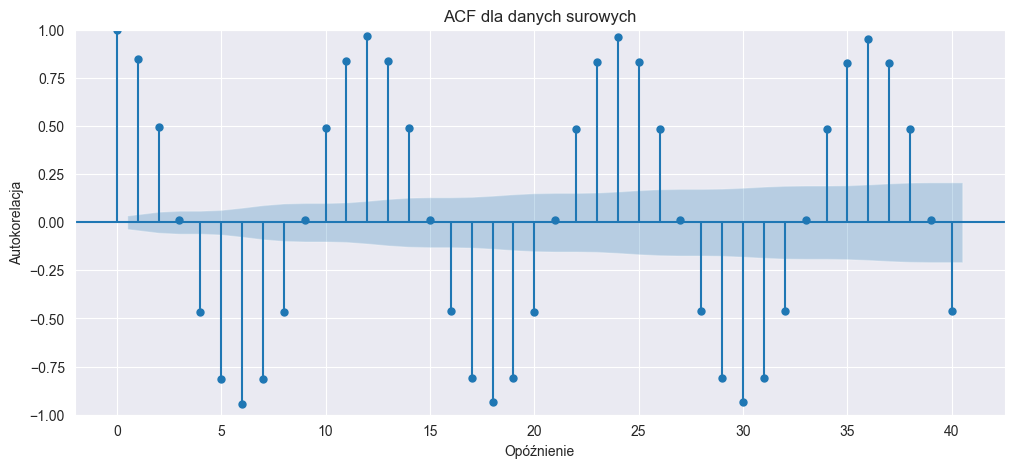

In [60]:
plt.figure(figsize=(12, 5))
plot_acf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')
plt.show()


Okres wynosi około 12

Test stacjonarności - Augmented Dickey-Fuller Test

In [61]:
def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [62]:
adfuller_test(temperature)

Statystyka testowa = -3.653, p-Value = 0.005 => Stationary. 


Dekompozycja

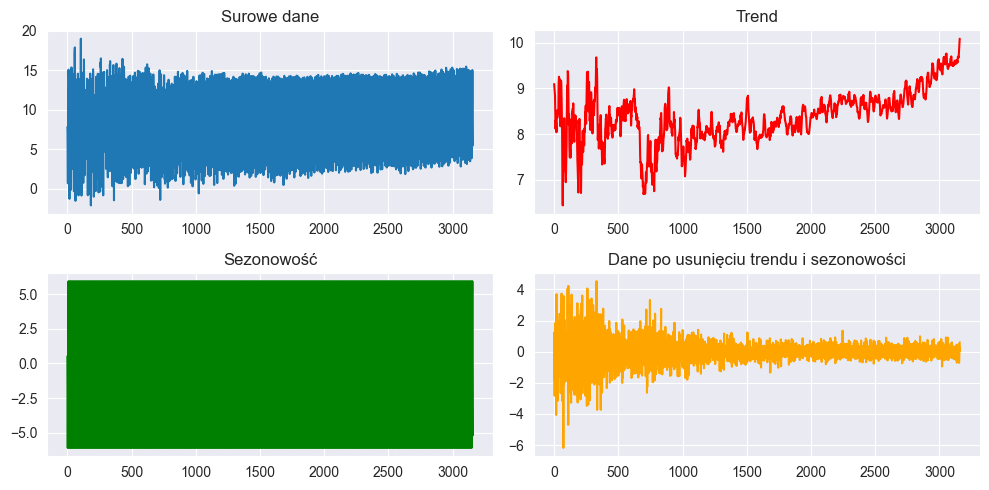

In [63]:
decomposition = seasonal_decompose(temperature, model='additive', period = 12, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(temperature, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

In [64]:
mae_residual = np.mean(np.abs(temperature - residual))
print(f"Mean Absolute Error: {mae_residual}")

Mean Absolute Error: 8.378634336054645


In [65]:
temperature_clean = residual

Sprawdzenie stacjonarności dla danych wyczyszczonych

In [66]:
adfuller_test(temperature_clean)

Statystyka testowa = -20.432, p-Value = 0.0 => Stationary. 


ACF i PACF dla wyczyszczonych danych

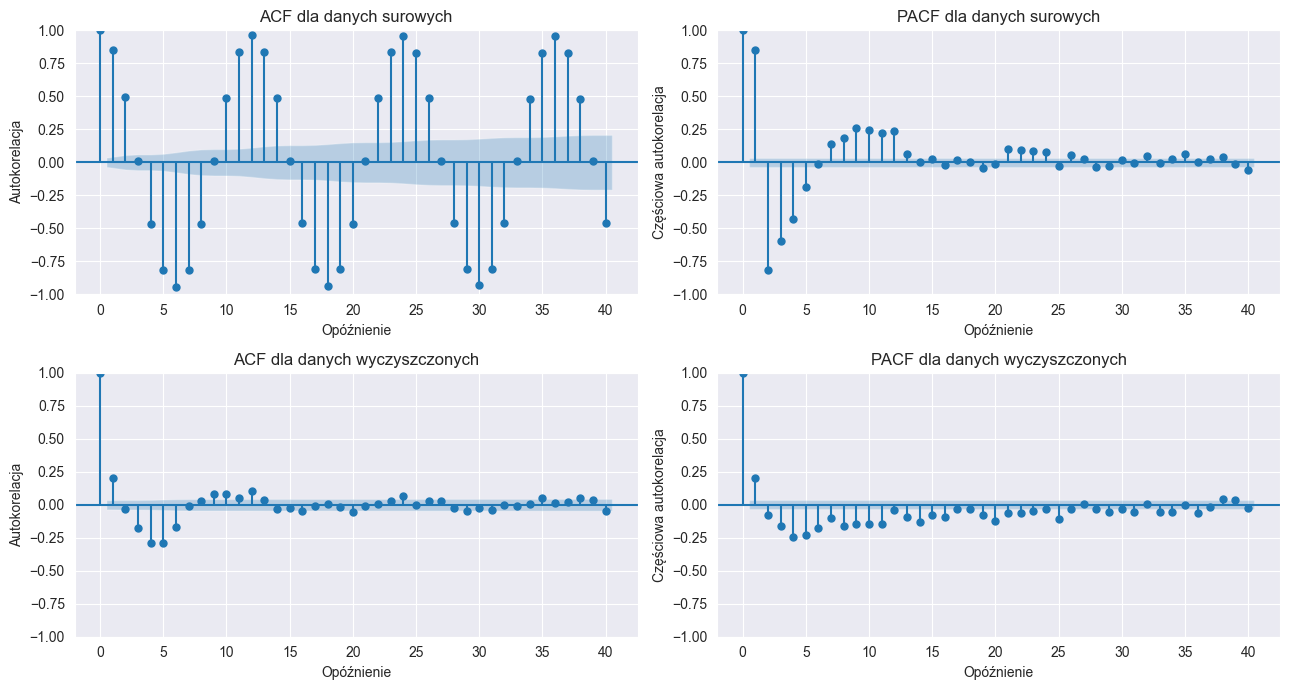

In [67]:
plt.figure(figsize=(13,7))

plt.subplot(223)
plot_acf(temperature_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych wyczyszczonych')

plt.subplot(224)
plot_pacf(temperature_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych wyczyszczonych')

plt.subplot(221)
plot_acf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')

plt.subplot(222)
plot_pacf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych surowych')

plt.tight_layout()
plt.show()

Dopasowanie modelu

In [68]:
df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

# Maksymalne wartości p i q
max_p = 5
max_q = 5

# Iteracja po możliwych wartościach p i q
for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(temperature_clean, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

c:\Users\rafal\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rafal\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\rafal\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\rafal\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

In [69]:
df.sort_values(by='AIC').head(1)

,p,q,AIC,BIC,HQIC
18,3,3,5622.464277,5670.928364,5639.850945


In [70]:
df.sort_values(by='BIC').head(1)

,p,q,AIC,BIC,HQIC
12,2,2,5632.10833,5668.456395,5645.148331


In [71]:
df.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC
18,3,3,5622.464277,5670.928364,5639.850945


In [113]:
model3 = pm.auto_arima(temperature_clean, 
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=5, 
                       max_q=5, 
                       max_order=None,
                       trace=True, 
                       seasonal=False, 
                       stepwise = False)
print(model3.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5489.697, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5489.898, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5490.145, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5490.642, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARI

Estymacja parametrów

In [72]:
p, q = 3,3

model = ARIMA(temperature_clean, order=(p, 0, q)).fit(method='innovations_mle')

print("Wyniki:")
print(model.summary())

Wyniki:
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                 3159
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -2794.596
Date:                Thu, 23 Jan 2025   AIC                           5605.191
Time:                        18:43:39   BIC                           5653.655
Sample:                             0   HQIC                          5622.578
                               - 3159                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.276e-06    2.4e-05     -0.386      0.699   -5.63e-05    3.78e-05
ar.L1          0.5561      0.008     65.954      0.000       0.540       0.573
ar.L2          0.7551      0.006    132.812 

Dopasowane parametry t-rozkladu: df=2.21, loc=-0.00, scale=0.30


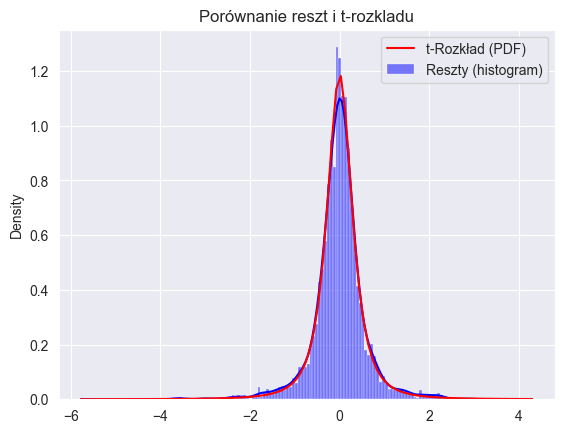

In [73]:
from scipy.stats import kstest, t, gamma
model_fit = ARIMA(temperature_clean, order=(p, 0, q)).fit(method='innovations_mle')

residuals = model_fit.resid

t_params = t.fit(residuals)
df, loc, scale = t_params

print(f"Dopasowane parametry t-rozkladu: df={df:.2f}, loc={loc:.2f}, scale={scale:.2f}")

import seaborn as sns

sns.histplot(residuals, kde=True, stat="density", label="Reszty (histogram)", color="blue")
x = np.linspace(min(residuals), max(residuals), 100)
plt.plot(x, t.pdf(x, df, loc, scale), label="t-Rozkład (PDF)", color="red")
plt.legend()
plt.title("Porównanie reszt i t-rozkladu")
plt.show()


In [74]:
ks_stat, p_value = kstest(residuals, 't', args=(df, loc, scale))

print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z t-rozkladu.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do t-rozkladu.")

Statystyka KS: 0.0114
P-wartość KS testu: 0.8013
Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z t-rozkladu.


In [180]:
gamma_params = gamma.fit(residuals)
shape, loc, scale = gamma_params

# Test Kolmogorova-Smirnova (KS test) dla gamma-rozkladu
ks_stat, p_value = kstest(residuals, 'gamma', args=(shape, loc, scale))

print(f"Dopasowane parametry gamma-rozkladu: shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z gamma-rozkladu.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do gamma-rozkladu.")

Dopasowane parametry gamma-rozkladu: shape=442.7909, loc=-12.7211, scale=0.0287
Statystyka KS: 0.1164
P-wartość KS testu: 0.0000
Odrzucamy hipotezę zerową - reszty nie pasują do gamma-rozkladu.


In [181]:
from scipy.stats import weibull_min
weibull_params = weibull_min.fit(residuals)
shape, loc, scale = weibull_params

# Test Kolmogorova-Smirnova (KS test) dla Weibull-rozkładu
ks_stat, p_value = kstest(residuals, 'weibull_min', args=(shape, loc, scale))

print(f"Dopasowane parametry Weibull-rozkładu: shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z Weibull-rozkładu.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do Weibull-rozkładu.")

Dopasowane parametry Weibull-rozkładu: shape=6.1721, loc=-3.8275, scale=4.0578
Statystyka KS: 0.1444
P-wartość KS testu: 0.0000
Odrzucamy hipotezę zerową - reszty nie pasują do Weibull-rozkładu.


In [182]:
from scipy.stats import norm, kstest

# Dopasowanie rozkładu normalnego do reszt
normal_params = norm.fit(residuals)
loc, scale = normal_params

# Test Kolmogorova-Smirnova (KS test) dla rozkładu normalnego
ks_stat, p_value = kstest(residuals, 'norm', args=(loc, scale))

print(f"Dopasowane parametry rozkładu normalnego: loc={loc:.4f}, scale={scale:.4f}")
print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z rozkładu normalnego.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do rozkładu normalnego.")


Dopasowane parametry rozkładu normalnego: loc=-0.0086, scale=0.5890
Statystyka KS: 0.1044
P-wartość KS testu: 0.0000
Odrzucamy hipotezę zerową - reszty nie pasują do rozkładu normalnego.


In [184]:
import numpy as np
from arch import arch_model

# Przeszukiwanie siatki dla GARCH(p, q)
best_aic = np.inf
best_order = None
best_model = None

for p in range(1, 4):  # Zakres dla p
    for q in range(1, 4):  # Zakres dla q
        try:
            model = arch_model(temperature_clean, vol='Garch', p=p, q=q, dist='t')
            results = model.fit(disp='off')
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)
                best_model = results
        except:
            continue

print(f"Najlepszy model: GARCH{best_order} z AIC: {best_aic}")
print(best_model.summary())


Najlepszy model: GARCH(1, 3) z AIC: 4517.1508710946555
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        resid   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2251.58
Distribution:      Standardized Student's t   AIC:                           4517.15
Method:                  Maximum Likelihood   BIC:                           4559.56
                                              No. Observations:                 3159
Date:                      Tue, Jan 21 2025   Df Residuals:                     3158
Time:                              00:36:38   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------

In [186]:
from arch import arch_model


model = arch_model(temperature_clean, vol='Garch', p=1, q=3, dist='t')
results = model.fit()

# Wyświetlenie wyników dopasowania
print(results.summary())


Iteration:      1,   Func. Count:      9,   Neg. LLF: 217603.68311040566
Iteration:      2,   Func. Count:     21,   Neg. LLF: 175296.40696075157
Iteration:      3,   Func. Count:     31,   Neg. LLF: 67193.40700751728
Iteration:      4,   Func. Count:     40,   Neg. LLF: 73915.04961209514
Iteration:      5,   Func. Count:     49,   Neg. LLF: 2283.470424414192
Iteration:      6,   Func. Count:     57,   Neg. LLF: 3810.437869697378
Iteration:      7,   Func. Count:     66,   Neg. LLF: 3852.4548868900874
Iteration:      8,   Func. Count:     80,   Neg. LLF: 3356.1317432619244
Iteration:      9,   Func. Count:     91,   Neg. LLF: 2265.980559342549
Iteration:     10,   Func. Count:    100,   Neg. LLF: 3240.0255760237123
Iteration:     11,   Func. Count:    109,   Neg. LLF: 2337.205663052859
Iteration:     12,   Func. Count:    118,   Neg. LLF: 2252.31030491221
Iteration:     13,   Func. Count:    126,   Neg. LLF: 2253.0764640186635
Iteration:     14,   Func. Count:    136,   Neg. LLF: 2257.